In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import copy
import math
import time
import random
from tqdm import tqdm
import webdataset as wds
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
import utils
from flat_models import *

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
# following fixes a Conv3D CUDNN_NOT_SUPPORTED error
torch.backends.cudnn.benchmark = True

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
if node is None:
    node = 0
else:
    node = int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
if global_rank is None:
    global_rank = 0
else:
    global_rank = int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
if world_size is None: 
    world_size = 1
else:
    world_size = int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in models.py or utils.py and 
    # have this notebook automatically update with your revisions
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

print("\n__CONFIG__")
for attribute_name in config.keys():
    if global_rank==0:
        print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

# Create outdir for ckpt and config.yaml
outdir = os.path.abspath(f'checkpoints/{model_name}')
print("outdir", outdir)

# Load previous config.yaml if available
if os.path.exists(f"{outdir}/config.yaml"):
    config = yaml.load(open(f"{outdir}/config.yaml", 'r'), Loader=yaml.FullLoader)
    print(f"Loaded config.yaml from ckpt folder {outdir}")

    # create global variables from the config
    print("\n__REPLACING_CONFIG__")
    for attribute_name in config.keys():
        if global_rank==0:
            print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")

data_type = torch.float32 # change depending on your mixed_precision
global_batch_size = batch_size * world_size

# FSDP Setup
if distributed:
    import torch.distributed as dist
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp import MixedPrecision
    from torch.distributed.fsdp.api import BackwardPrefetch, CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    dist.init_process_group("nccl", rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier() 
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 1
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1

__CONFIG__
model_name = hcpflat_large_gsrFalse
datasets_to_include = HCP
hcp_flat_path = /weka/proj-medarc/shared/HCP-Flat
nsd_flat_path = /weka/proj-medarc/shared/NSD-Flat
gsr = False
use_contrastive_loss = False
patch_size = 16
pct_masks_to_decode = 1
decoder_embed_dim = 512
num_frames = 16
mask_ratio = 0.75
pred_t_dim = 8
t_patch_size = 2
cls_embed = True
no_qkv_bias = False
sep_pos_embed = True
trunc_init = False
norm_pix_loss = False
contrastive_loss_weight = 1.0
batch_size = 32
num_workers = 10
num_epochs = 5
seed = 42
base_lr = 0.001
num_samples_per_epoch = 200000
test_num_samples_per_epoch = 50000
grad_clip = 1.0
grad_accumulation_steps = 1
test_set = False
plotting = True
probe_num_samples_per_epoch = 100000
probe_num_epochs = 30
probe_batch_size = 8
probe_base_lr = 0.0003
ckpt_saving = True
ckpt_interval = 5
print_interval = 20
resume_from_ckpt = False
wandb_log = True


outdir /wek

# hcp_flat

In [2]:
from util.flat import load_hcp_flat_mask, load_nsd_flat_mask
from util.flat import create_hcp_flat, create_nsd_flat
from util.flat import unmask, batch_unmask
import util.visualize as vis

## Create dataset and data loaders

In [3]:
num_batches = num_samples_per_epoch // (num_devices * batch_size)
print("num_batches", num_batches)
test_num_batches = test_num_samples_per_epoch // (num_devices * batch_size)
if test_set: print("test_num_batches", test_num_batches)

## Train ##
if "HCP" in datasets_to_include:
    train_dataset = create_hcp_flat(root=hcp_flat_path, 
                    frames=num_frames, shuffle=True,
                    gsr=gsr)
    flat_mask = load_hcp_flat_mask()
elif "NSD" in datasets_to_include:
    train_dataset = create_nsd_flat(root=nsd_flat_path, 
                    frames=num_frames, shuffle=True,
                    gsr=gsr)
    flat_mask = load_nsd_flat_mask()
train_dl = wds.WebLoader(
    train_dataset.batched(batch_size, partial=False),
    batch_size=None,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
train_dl = train_dl.with_epoch(num_batches)

num_batches 6250
Shuffle buffer size: 8428


## Create model

In [4]:
model = mae_vit_large_fmri(
    patch_size=patch_size,
    decoder_embed_dim=decoder_embed_dim,
    t_patch_size=t_patch_size,
    pred_t_dim=pred_t_dim,
    decoder_depth=4,
    cls_embed=cls_embed,
    norm_pix_loss=norm_pix_loss,
    no_qkv_bias=no_qkv_bias,
    sep_pos_embed=sep_pos_embed,
    trunc_init=trunc_init,
    pct_masks_to_decode=pct_masks_to_decode,
    img_mask=flat_mask,
)

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized


### Check data loaders work

Yielding 2 batches


  0%|                                                  | 0/6250 [00:00<?, ?it/s]

iter 0


  0%|                                        | 2/6250 [00:03<2:58:58,  1.72s/it]


epochs 2
input_func torch.Size([32, 1, 16, 144, 320])
Execution time: 3.4405324459075928 seconds


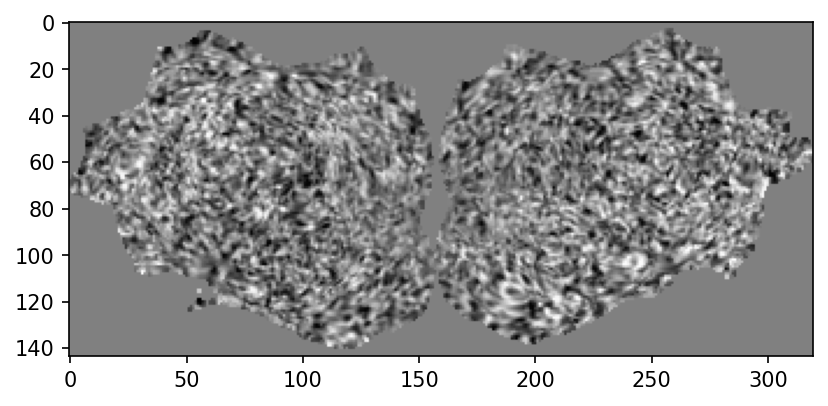

In [5]:
if utils.is_interactive():
    subject_list = []
    task_list = []
    
    start_time = time.time() 
    num_it = 2
    print(f"Yielding {num_it} batches")
    
    for i, batch in enumerate(tqdm(train_dl, total=num_batches)):
        input_func = batch[0]
        
        if i==0: print("iter",i)
        if i >= (num_it):
            break
            
        plt.imshow(input_func[0,0,0], cmap='gray')
    
    print("epochs", i)
    print("input_func", input_func.shape)

    end_time = time.time()  
    execution_time = end_time - start_time  
    print(f"Execution time: {execution_time} seconds")

# Set up optimizer and saving functions

In [6]:
print(f"\nChecking distributed setup on global_rank {global_rank}...")
from util.video_vit import Attention
if distributed:
    my_auto_wrap_policy = functools.partial(
        transformer_auto_wrap_policy, 
        transformer_layer_cls={Attention,},
    )
    
    print(f"\nPrepping FSDP on {global_rank} {node}...\n")
    model = model.to(device)
    
    # FSDP
    model = FSDP(
        model,
        sharding_strategy=None,#ShardingStrategy.FULL_SHARD, 
        auto_wrap_policy=my_auto_wrap_policy,
        use_orig_params=False,
        cpu_offload=None,#CPUOffload(offload_params=True), 
        sync_module_states=True,  # Synchronize module states at the beginning
        limit_all_gathers=True,  # See https://github.com/pytorch/pytorch/issues/91165
        device_id=device,
        mixed_precision=MixedPrecision(param_dtype=torch.float32, reduce_dtype=torch.float32, buffer_dtype=torch.float32),
    )
    
    print(f"\nSuccessfully loaded FSDP model to device on global_rank {global_rank}\n")
    dist.barrier()
else:
    print(f"\nNot training distributed! global_rank {global_rank}")
    model.to(device)


Checking distributed setup on global_rank 0...

Not training distributed! global_rank 0


In [7]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = base_lr * global_batch_size / 256
print(f"multiply base lr {base_lr} by effective batch size {global_batch_size}")
print(f"lr = {lr}")

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=lr, betas=(0.9, 0.95))

def adjust_learning_rate(optimizer, epoch, warmup_epochs=5, min_lr=0.0):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr_ = lr * epoch / warmup_epochs
    else:
        lr_ = min_lr + (lr - min_lr) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (epoch - warmup_epochs)
                / (num_epochs - warmup_epochs)
            )
        )
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_
    return lr_

print("\nDone with model preparations!")
num_params = utils.count_params(model)

multiply base lr 0.001 by effective batch size 32
lr = 0.000125

Done with model preparations!
param counts:
316,395,776 total
316,395,776 trainable


In [8]:
def save_ckpt(model,tag="last"):
    if distributed: dist.barrier()
    model_states = model.state_dict()
    optimizer_states = optimizer.state_dict()
    if global_rank == 0:
        os.makedirs(outdir,exist_ok=True)
        ckpt_path = outdir+f'/{tag}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_states,
            'optimizer_state_dict': optimizer_states,
        }, ckpt_path)
        print(f"\n---saved {ckpt_path}!---\n")
        
        # save the config.yaml
        if not os.path.exists(f"{outdir}/config.yaml"):
            with open(f"{outdir}/config.yaml", 'w') as file:
                yaml.dump(config, file)
            print(f"saved {outdir}/config.yaml!")

# Load checkpoint

In [9]:
epoch = 0
if resume_from_ckpt:
    if not os.path.exists(outdir) or not os.path.isdir(outdir):
        print(f"\nNot resuming from ckpt. Checkpoint folder {outdir} does not exist.\n")
    else:
        checkpoint_files = [f for f in os.listdir(outdir) if f.endswith('.pth')]

        # Extract epoch numbers and find the largest
        epoch_numbers = []
        for file in checkpoint_files:
            try:
                epoch_number = int(file.split('epoch')[-1].split('.')[0])
                epoch_numbers.append(epoch_number)
            except ValueError:
                continue

        latest_epoch = max(epoch_numbers)
        latest_checkpoint = f"epoch{latest_epoch}.pth"

        # Load the checkpoint
        checkpoint_path = os.path.join(outdir, latest_checkpoint)

        state = torch.load(checkpoint_path)
        model.load_state_dict(state["model_state_dict"], strict=True)
        epoch = state['epoch'] + 1
        
        # Optimizer loading
        saved_state_dict = state['optimizer_state_dict']
        # adjust the saved state dict to match the current optimizer's structure
        for i, group in enumerate(optimizer.param_groups):
            # Ensure the params in the saved state match the current optimizer's params
            saved_state_dict['param_groups'][i]['params'] = group['params']
        optimizer.load_state_dict(saved_state_dict)

        print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}. Epoch = {epoch}\n")

# Start wandb (if enabled)

In [10]:
if utils.is_interactive():
    wandb_log = False
    ckpt_saving = False
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'fMRI-foundation-model'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "cls_embed": cls_embed,
      "norm_pix_loss": norm_pix_loss,
      "patch_size": patch_size,
      "t_patch_size": t_patch_size,
      "pred_t_dim": pred_t_dim,
      "mask_ratio": mask_ratio,
      "num_frames": num_frames,
      "sep_pos_embed": sep_pos_embed,
      "decoder_embed_dim": decoder_embed_dim,
      "use_contrastive_loss": use_contrastive_loss,
      "num_params": num_params,
      "base_lr": base_lr,
      "lr": lr,
      "num_samples_per_epoch": num_samples_per_epoch,
      "test_num_samples_per_epoch": test_num_samples_per_epoch,
      "test_set": test_set,
      "grad_clip": grad_clip,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "print_interval": print_interval,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "grad_accumulation_steps": grad_accumulation_steps,
      "world_size": world_size,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
    
    # Reprint the config so that wandb captures it in the output log
    print("\n__CONFIG__")
    for attribute_name in config.keys():
        if global_rank==0:
            print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")
else:
    wandb_log = False

# Start training

In [11]:
lrs, train_losses, test_losses = [], [], []
train_losses1, train_losses2, train_losses3 = [], [], []

mse = nn.MSELoss()
l1 = nn.L1Loss()
crossentropy = nn.CrossEntropyLoss()

if use_contrastive_loss:
    contrastive_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs)

In [12]:
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
progress_bar = tqdm(range(epoch, num_epochs), disable=local_rank!=0, desc="Overall")
for epoch in progress_bar:
    model.train()
    for train_i, batch in enumerate(train_dl):
        adjust_learning_rate(optimizer, train_i / num_batches + epoch)

        input_func = batch[0].to(device=device, non_blocking=True)

        if not use_contrastive_loss:
            loss, pred, mask, latent = model(input_func, mask_ratio=mask_ratio, use_contrastive_loss=use_contrastive_loss)
        else:
            loss1, loss2, loss3, pred1, pred2, mask1, mask2, true_mask, latent1, latent2 = model(input_func, mask_ratio=mask_ratio, use_contrastive_loss=use_contrastive_loss)
            pred, mask = pred1, mask1

            loss = loss1 + loss2 + loss3
            
            train_losses1.append(loss1.item())
            train_losses2.append(loss2.item())
            train_losses3.append(loss3.item())

        loss = loss / grad_accumulation_steps # normalize the loss by grad accumulation steps
        grad_scaler.scale(loss).backward()
        
        if (train_i + 1) % grad_accumulation_steps == 0:
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            optimizer.zero_grad()
            torch.cuda.synchronize()

        lrs.append(optimizer.param_groups[0]["lr"])
        train_losses.append(loss.item() * grad_accumulation_steps)
        
        if ((train_i%print_interval)==0 or (train_i==num_batches-1)) and train_i>0:
            print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
            if wandb_log: 
                if not use_contrastive_loss:
                    logs = {"train/loss": np.mean(train_losses[-print_interval:])}
                else:
                    logs = {"train/loss": np.mean(train_losses[-print_interval:]),
                            "train/loss1": np.mean(train_losses1[-print_interval:]),
                            "train/loss2": np.mean(train_losses2[-print_interval:]),
                            "train/loss3": np.mean(train_losses3[-print_interval:]),
                           }
                # epoch_1000x as x-axis calibrates different curves when batch size changes
                epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                wandb.log(logs, step=epoch_1000x)
                
    print(f"\nPassed training epoch {epoch}")
    if (train_i + 1) % grad_accumulation_steps != 0:
        print("update last batch that didnt divide evenly by grad accum.")
        grad_scaler.unscale_(optimizer)
        if not distributed:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
        else:
            model.clip_grad_norm_(max_norm=grad_clip)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        optimizer.zero_grad()
        torch.cuda.synchronize()
                
    if utils.is_interactive() or wandb_log:
        print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
        if plotting:
            with torch.no_grad():
                print("\n Train plotting...")
                if norm_pix_loss:
                    normed_input_func, patch_info = model.patchify(input_func, alter_patch_info=False, return_patch_info=True)
                    target_mean = normed_input_func.mean(dim=-1, keepdim=True)
                    target_var = normed_input_func.var(dim=-1, keepdim=True)
                    normed_input_func = (normed_input_func - target_mean) / (target_var + 1.0e-6) ** 0.5
                    normed_input_func = model.unpatchify(normed_input_func, patch_info=patch_info)
    
                    vis_out = vis.plot_mask_pred(
                        model, normed_input_func, pred, mask, 
                        mean=0.5, std=0.2, 
                    )
                else:
                    vis_out = vis.plot_mask_pred(
                        model, input_func, pred, mask, 
                        mean=0.5, std=0.2, 
                    )
    
                if wandb_log:
                    logs = {"train/mask_pred": wandb.Image(vis_out)}
                    epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                    wandb.log(logs, step=epoch_1000x)
                else:
                    display(vis_out)

    # Save model checkpoint
    if ckpt_saving and epoch>0 and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
        save_ckpt(model,f"epoch{epoch}")

    # wait for other GPUs to catch up if needed
    if distributed: dist.barrier()
    
    # close any open plots
    plt.close()
    
if distributed: dist.destroy_process_group()

Overall:   0%|                                            | 0/5 [00:00<?, ?it/s]

Ep. 0 | loss 2.308 | lr 8e-08 | 20/6250
Ep. 0 | loss 2.180 | lr 1.6e-07 | 40/6250
Ep. 0 | loss 1.970 | lr 2.4e-07 | 60/6250
Ep. 0 | loss 1.712 | lr 3.2e-07 | 80/6250
Ep. 0 | loss 1.493 | lr 4e-07 | 100/6250
Ep. 0 | loss 1.348 | lr 4.8e-07 | 120/6250
Ep. 0 | loss 1.220 | lr 5.599999999999999e-07 | 140/6250
Ep. 0 | loss 1.128 | lr 6.4e-07 | 160/6250
Ep. 0 | loss 1.081 | lr 7.2e-07 | 180/6250
Ep. 0 | loss 1.037 | lr 8e-07 | 200/6250
Ep. 0 | loss 1.020 | lr 8.8e-07 | 220/6250
Ep. 0 | loss 1.007 | lr 9.6e-07 | 240/6250
Ep. 0 | loss 1.001 | lr 1.04e-06 | 260/6250
Ep. 0 | loss 0.989 | lr 1.1199999999999999e-06 | 280/6250
Ep. 0 | loss 0.992 | lr 1.2e-06 | 300/6250


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51079ead40>
Traceback (most recent call last):
  File "/admin/home-paulscotti/found2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/admin/home-paulscotti/found2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_li